## **Generative Adversarial Networks for Synthesizing New Data (Part 2/2)**

### **Improving the quality of synthesized images using a convolutional and Wasserstein GAN**


### **Implementing the generator and discriminator**

**Architecture design considerations for convolutional GANs**

Notice that the number of feature maps follows different trends between the `generator` and the `discriminator`. In the generator, we start with a large number of feature maps and decrease them as we progress toward the last layer. On the other hand, in the discriminator, we start with a small number of channels and increase it toward the last layer. This is an important point for designing `CNNs` with the number of feature maps and the spatial size of the feature maps in reverse order. When the spatial size of the feature maps increases, the number of feature maps decreases and vice versa.


In addition, note that it’s usually not recommended to use `bias units` in the layer that follows a `BatchNorm layer`. Using bias units would be redundant in this case, since `BatchNorm` already has a shift parameter, $\beta$ . You can omit the bias units for a given layer by setting `bias=False` in `nn.ConvTranspose2d` or `nn.Conv2d`.

In [5]:
import torch


print(torch.__version__)
print("GPU Available:", torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

2.8.0+cu126
GPU Available: True


In [6]:
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

**Train the DCGAN model**

In [7]:
import torchvision
from torchvision import transforms


image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

batch_size = 64

torch.manual_seed(1)
np.random.seed(1)

## Set up the dataset
from torch.utils.data import DataLoader
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size,
                      shuffle=True, drop_last=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 451kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.1MB/s]


In [8]:
def make_generator_network(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0,
                           bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())
    return model

class Discriminator(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

- With the helper function and class, you can build a `DCGAN` model and train it by using the same `MNIST` dataset object we initialized in the previous section when we implemented the simple, fully connected GAN. We can create the generator networks using the helper function and print its architecture as follows:

In [9]:
z_size = 100
image_size = (28, 28)
n_filters = 32

gen_model = make_generator_network(z_size, n_filters).to(device)
print(gen_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)


- Similarly, we can generate the discriminator network and see its architecture:

In [10]:
disc_model = Discriminator(n_filters).to(device)
print(disc_model)

Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [11]:
## Loss function and optimizers:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

- The `create_noise()` function for generating random input must change to output a tensor of four dimensions instead of a vector

In [12]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size, 1, 1)*2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size, 1, 1)
    return input_z

- The `d_train()` function for training the discriminator doesn’t need to reshape the input image:

In [13]:
## Train the discriminator
def d_train(x):
    disc_model.zero_grad()

    # Train discriminator with a real batch
    batch_size = x.size(0)
    x = x.to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    # Train discriminator on a fake batch
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # gradient backprop & optimize ONLY D's parameters
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [14]:
## Train the generator
def g_train(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones((batch_size, 1), device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

- Next, we will alternate between the training of the generator and the discriminator for `100` epochs. After each epoch, we will generate some examples from a fixed noise input using the current generator model by calling the `create_samples()` function.

In [15]:
mode_z = 'uniform'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0

epoch_samples = []

num_epochs = 100
torch.manual_seed(1)

for epoch in range(1, num_epochs+1):
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))

    print(f'Epoch {epoch:03d} | Avg Losses >>'
          f' G/D {torch.FloatTensor(g_losses).mean():.4f}'
          f'/{torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001 | Avg Losses >> G/D 4.8767/0.0962
Epoch 002 | Avg Losses >> G/D 5.0479/0.1185
Epoch 003 | Avg Losses >> G/D 4.1788/0.2360
Epoch 004 | Avg Losses >> G/D 3.3012/0.3071
Epoch 005 | Avg Losses >> G/D 3.0491/0.3349
Epoch 006 | Avg Losses >> G/D 2.8291/0.3813
Epoch 007 | Avg Losses >> G/D 2.8026/0.3736
Epoch 008 | Avg Losses >> G/D 2.8348/0.3184
Epoch 009 | Avg Losses >> G/D 2.9382/0.3363
Epoch 010 | Avg Losses >> G/D 3.0269/0.2880
Epoch 011 | Avg Losses >> G/D 3.0424/0.2757
Epoch 012 | Avg Losses >> G/D 3.1909/0.2579
Epoch 013 | Avg Losses >> G/D 3.1433/0.2668
Epoch 014 | Avg Losses >> G/D 3.2699/0.2503
Epoch 015 | Avg Losses >> G/D 3.3040/0.2609
Epoch 016 | Avg Losses >> G/D 3.3961/0.2287
Epoch 017 | Avg Losses >> G/D 3.4117/0.2376
Epoch 018 | Avg Losses >> G/D 3.4785/0.2266
Epoch 019 | Avg Losses >> G/D 3.4778/0.2252
Epoch 020 | Avg Losses >> G/D 3.6073/0.2357
Epoch 021 | Avg Losses >> G/D 3.6034/0.2003
Epoch 022 | Avg Losses >> G/D 3.6541/0.1931
Epoch 023 | Avg Losses >> G/D 3.

- Finally, let’s visualize the saved examples at some epochs to see how the model is learning and how
the quality of synthesized examples changes over the course of learning:

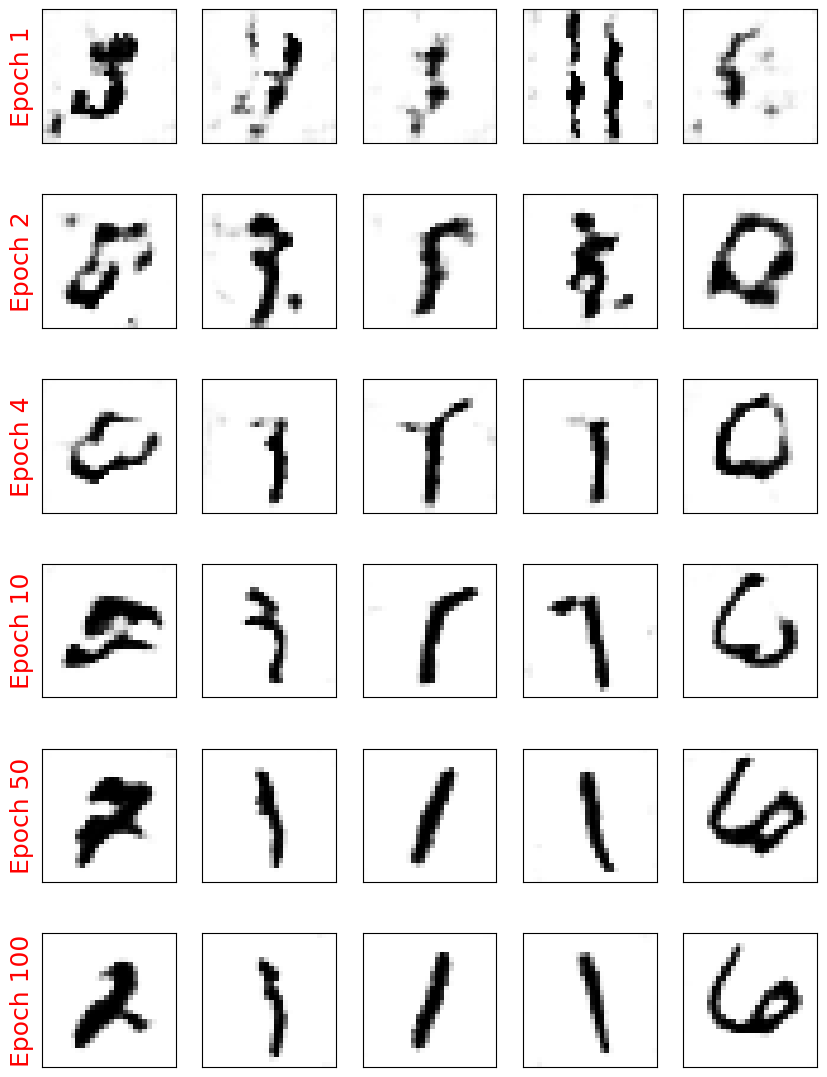

In [16]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes)

        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

# plt.savefig('figures/ch17-dcgan-samples.pdf')
plt.show()

- We used the same code to visualize the results as in the section on vanilla GAN. Comparing the new examples shows that `DCGAN` can generate images of a much higher quality.


- You may wonder how we can evaluate the results of GAN generators. The simplest approach is visual assessment, which involves evaluating the quality of the synthesized images in the context of the target domain and the project objective.


- There is a theoretical argument that training the generator should seek to minimize the dissimilarity between the distribution observed in the real data and the distribution observed in synthesized examples. Hence our current architecture would not perform very well when using cross-entropy as
a loss function.

---

### **Dissimilarity measures between two distributions**


#### **Implementing WGAN-GP to train the DCGAN model**

- It is recommended to use `layer normalization` in `WGAN` instead of `batch normalization`.

- `Layer normalization` normalizes the inputs across features instead of across the batch dimension in batch normalization.

In [17]:
def make_generator_network_wgan(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0,
                           bias=False),
        nn.InstanceNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())
    return model

class DiscriminatorWGAN(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

- Now we initiate the networks and their optimizers as follows:

In [18]:
gen_model = make_generator_network_wgan(z_size, n_filters).to(device)
disc_model = DiscriminatorWGAN(n_filters).to(device)

g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0002)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

- We define the function to compute the `GP` component as follows:

In [19]:
from torch.autograd import grad as torch_grad

def gradient_penalty(real_data, generated_data):
    batch_size = real_data.size(0)

    # Calculate interpolation
    alpha = torch.rand(real_data.shape[0], 1, 1, 1, requires_grad=True, device=device)
    interpolated = alpha * real_data + (1 - alpha) * generated_data

    # Calculate probability of interpolated examples
    proba_interpolated = disc_model(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=proba_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(proba_interpolated.size(), device=device),
                           create_graph=True, retain_graph=True)[0]

    gradients = gradients.view(batch_size, -1)
    gradients_norm = gradients.norm(2, dim=1)
    return lambda_gp * ((gradients_norm - 1)**2).mean()

- The `WGAN` version of discriminator and generator training functions are as follows:

In [20]:
## Train the discriminator
def d_train_wgan(x):
    disc_model.zero_grad()

    batch_size = x.size(0)
    x = x.to(device)

    # Calculate probabilities on real and generated data
    d_real = disc_model(x)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_generated = disc_model(g_output)
    d_loss = d_generated.mean() - d_real.mean() + gradient_penalty(x.data, g_output.data)
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item()

In [21]:
## Train the generator
def g_train_wgan(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_generated = disc_model(g_output)
    g_loss = -d_generated.mean()

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

- Train model for `100` epochs and record the generator output of a fixed noise input:

In [ ]:
epoch_samples_wgan = []
lambda_gp = 10.0
num_epochs = 100
torch.manual_seed(1)
critic_iterations = 5

for epoch in range(1, num_epochs+1):
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        for _ in range(critic_iterations):
            d_loss = d_train_wgan(x)
        d_losses.append(d_loss)
        g_losses.append(g_train_wgan(x))

    print(f'Epoch {epoch:03d} | D Loss >>'
          f' {torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples_wgan.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001 | D Loss >> -0.2991
Epoch 002 | D Loss >> -0.5463
Epoch 003 | D Loss >> -0.5683
Epoch 004 | D Loss >> -0.5402
Epoch 005 | D Loss >> -0.5262
Epoch 006 | D Loss >> -0.4988
Epoch 007 | D Loss >> -0.4892
Epoch 008 | D Loss >> -0.4803
Epoch 009 | D Loss >> -0.4767
Epoch 010 | D Loss >> -0.4766
Epoch 011 | D Loss >> -0.4704
Epoch 012 | D Loss >> -0.4613
Epoch 013 | D Loss >> -0.4608
Epoch 014 | D Loss >> -0.4583
Epoch 015 | D Loss >> -0.4572
Epoch 016 | D Loss >> -0.4561
Epoch 017 | D Loss >> -0.4564
Epoch 018 | D Loss >> -0.4598
Epoch 019 | D Loss >> -0.4609
Epoch 020 | D Loss >> -0.4596
Epoch 021 | D Loss >> -0.4598
Epoch 022 | D Loss >> -0.4592
Epoch 023 | D Loss >> -0.4624
Epoch 024 | D Loss >> -0.4606
Epoch 025 | D Loss >> -0.4572
Epoch 026 | D Loss >> -0.4616
Epoch 027 | D Loss >> -0.4593
Epoch 028 | D Loss >> -0.4650
Epoch 029 | D Loss >> -0.4673
Epoch 030 | D Loss >> -0.4683
Epoch 031 | D Loss >> -0.4681
Epoch 032 | D Loss >> -0.4740
Epoch 033 | D Loss >> -0.4646
Epoch 034 

- Visualize the saved examples at some epochs to see how the `WGAN` model is learning and how the quality of synthesized examples changes over the course of learning.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
selected_epochs = [1, 2, 4, 10, 50, 100]
# selected_epochs = [1, 10, 20, 30, 50, 70]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes)

        image = epoch_samples_wgan[e-1][j]
        ax.imshow(image, cmap='gray_r')

# plt.savefig('figures/ch17-wgan-gp-samples.pdf')
plt.show()

In [ ]:
1